In [ ]:
##get_ipython().kernel.do_shutdown(restart=True)       # Tor Restart the Kernal explicitly

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')

In [ ]:
!nvidia-smi
# this should display information about available GPUs
!pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com
import cudf
# this should work without any errors
!pip install plotly-express
%load_ext cudf.pandas

/bin/bash: line 1: nvidia-smi: command not found
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


ImportError: 
================================================================
Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory
================================================================


In [ ]:
# Step 1: Problem Formulation

# Load necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

#**Data Preprocessing**

## **Data Profiling**

In [ ]:
# Load train and test datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [ ]:
train_data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [ ]:
train_data.tail()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0
1999,510,1,2.0,1,5,1,45,0.9,168,6,...,483,754,3919,19,4,2,1,1,1,3


In [ ]:
train_data.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [ ]:
# Correct the data types of the features
train_data['battery_power'] = train_data['battery_power'].astype('int64')
train_data['blue'] = train_data['blue'].astype('bool')
train_data['clock_speed'] = train_data['clock_speed'].astype('float64')
train_data['dual_sim'] = train_data['dual_sim'].astype('bool')
train_data['fc'] = train_data['fc'].astype('int64')
train_data['four_g'] = train_data['four_g'].astype('bool')
train_data['int_memory'] = train_data['int_memory'].astype('int64')
train_data['m_dep'] = train_data['m_dep'].astype('float64')
train_data['mobile_wt'] = train_data['mobile_wt'].astype('int64')
train_data['n_cores'] = train_data['n_cores'].astype('int64')
train_data['pc'] = train_data['pc'].astype('int64')
train_data['px_height'] = train_data['px_height'].astype('int64')
train_data['px_width'] = train_data['px_width'].astype('int64')
train_data['ram'] = train_data['ram'].astype('int64')
train_data['sc_h'] = train_data['sc_h'].astype('int64')
train_data['sc_w'] = train_data['sc_w'].astype('int64')
train_data['talk_time'] = train_data['talk_time'].astype('int64')
train_data['three_g'] = train_data['three_g'].astype('bool')
train_data['touch_screen'] = train_data['touch_screen'].astype('bool')
train_data['wifi'] = train_data['wifi'].astype('bool')
train_data['price_range'] = train_data['price_range'].astype('int64')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   bool   
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   bool   
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   bool   
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   bool   
 18  touch_sc

## **Data Cleansing**

### **Handling Missing Values**

In [ ]:
print(train_data.isnull().sum())

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64


In [ ]:
# Check for duplicates in the train dataset
print("Duplicates in train dataset:", train_data.duplicated().sum())


Duplicates in train dataset: 0


In [ ]:
# Remove duplicates (if any)
#  train_data.drop_duplicates(inplace=True)

### **Noisy Data Reduction**

We use certain techniques to clean noisy data :


1.   **Binning**
2.   **Regression**
3.   **Clustering**



In [ ]:
# List of numerical columns in the dataset
numerical_columns = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep',
                     'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width',
                     'ram', 'sc_h', 'sc_w', 'talk_time']

# Specify the number of bins
num_bins = 5

# Iterate over each numerical column and apply binning
for column in numerical_columns:
    train_data[column + '_binned'] = pd.cut(train_data[column], bins=num_bins, labels=False)



In this code:



*   numerical_columns is a list containing the names of all numerical columns in your dataset.
*   num_bins specifies the number of bins you want to create for each numerical column.
*   We iterate over each numerical column, apply binning using pd.cut(), and create a new column with the suffix _binned appended to the original column name.

After running this code, your training dataset train_data will have additional columns for each numerical feature, with bin numbers corresponding to the values in each respective column. Adjust the list of numerical columns and the number of bins as needed based on your specific dataset and requirements.

The output will display the first few rows of the modified training dataset with the newly added binned columns for each numerical feature. You can adjust the display as needed to view more rows or specific columns.

# **Removing Outliers**

In [ ]:
# Import necessary libraries
from sklearn.cluster import DBSCAN

# Specify the best columns (replace 'best_columns' with your list of best column names)
best_columns = ['ram', 'battery_power', 'px_height', 'px_width']

# Specify parameters for DBSCAN
eps = 3
min_samples = 2

# Iterate over the best columns and perform outlier detection
for column in best_columns:
    # Extract the column data
    column_data = train_data[column].values.reshape(-1, 1)

    # Create an instance of DBSCAN outlier detector
    outlier_detector = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the DBSCAN model to detect outliers
    outliers = outlier_detector.fit_predict(column_data)

    # Display the indices of outliers
    print(f"Outliers in column '{column}':")
    print(np.where(outliers == -1)[0])


Outliers in column 'ram':
[   8   83  102  163  231  269  368  419  454  523  529  580  608  617
  633  661  685  719  755  803  804  815  840  937  943  949  973  987
 1075 1121 1176 1197 1254 1267 1314 1333 1394 1409 1438 1466 1485 1529
 1560 1721 1723 1779 1785 1936 1954 1967 1968 1973 1994]
Outliers in column 'battery_power':
[]
Outliers in column 'px_height':
[ 107  109  148  219  260  265  274  292  305  367  372  525  714  873
  894  961  988 1017 1018 1075 1197 1353 1397 1414 1472 1473 1532 1552
 1615 1692 1771 1902]
Outliers in column 'px_width':
[]


In [ ]:
# Create a copy of the training data to preserve the original
cleaned_train_data = train_data.copy()

# Iterate over the best columns and remove outliers from the dataset
for column in best_columns:
    # Extract the column data
    column_data = train_data[column].values.reshape(-1, 1)

    # Create an instance of DBSCAN outlier detector
    outlier_detector = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the DBSCAN model to detect outliers
    outliers = outlier_detector.fit_predict(column_data)

    # Get the indices of outliers
    outlier_indices = np.where(outliers == -1)[0]

    # Remove outliers from the cleaned dataset
    cleaned_train_data = cleaned_train_data.drop(cleaned_train_data.index[outlier_indices])

# Print the cleaned dataset
print("Cleaned Training Data:")
print(cleaned_train_data)




Cleaned Training Data:
      battery_power   blue  clock_speed  dual_sim  fc  four_g  int_memory  \
0               842  False          2.2     False   1   False           7   
1              1021   True          0.5      True   0    True          53   
2               563   True          0.5      True   2    True          41   
3               615   True          2.5     False   0   False          10   
4              1821   True          1.2     False  13    True          44   
...             ...    ...          ...       ...  ..     ...         ...   
1995            794   True          0.5      True   0    True           2   
1996           1965   True          2.6      True   0   False          39   
1997           1911  False          0.9      True   1    True          36   
1998           1512  False          0.9     False   4    True          46   
1999            510   True          2.0      True   5    True          45   

      m_dep  mobile_wt  n_cores  ...  m_dep_binned  

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming your data is stored in a DataFrame named 'data'
X = cleaned_train_data.drop(columns=['price_range'])  # Features
y = cleaned_train_data['price_range']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from sklearn.feature_selection import SelectKBest, f_classif

# Specify the number of features to select (replace k with your desired number)
k = 10

# Instantiate SelectKBest with the f_classif scoring function
selector = SelectKBest(score_func=f_classif, k=k)

# Fit the selector to the training data and transform the features
X_selected = selector.fit_transform(X_train, y_train)

# Get the selected feature indices
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X.columns[selected_indices]

print("Selected Features:")
for feature in selected_features:
    print(feature)


Selected Features:
battery_power
mobile_wt
px_height
px_width
ram
battery_power_binned
px_height_binned
px_width_binned
ram_binned
sc_w_binned


In [ ]:
from sklearn.preprocessing import StandardScaler

# Apply log transformation to address skewness for each best column
X_selected_log = X_selected.copy()  # Make a copy to preserve original data
for i in range(X_selected_log.shape[1]):
    X_selected_log[:, i] = np.log1p(X_selected_log[:, i])  # Apply log transformation

# Standardization using StandardScaler
scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(X_selected_log)


In this code:

We apply log transformation to the selected features using np.log1p().
Then, we perform standardization using StandardScaler() to scale the features to have a mean of 0 and a standard deviation of 1.
This ensures that the selected features are processed appropriately for further modeling. Let me know if you need further assistance!

In [ ]:
# Output the selected features
print("Selected Features:")
print(selected_features)

# Output the scaled and transformed features
print("\nScaled and Transformed Features (first 5 rows):")
print(X_selected_scaled[:5])

Selected Features:
Index(['battery_power', 'mobile_wt', 'px_height', 'px_width', 'ram',
       'battery_power_binned', 'px_height_binned', 'px_width_binned',
       'ram_binned', 'sc_w_binned'],
      dtype='object')

Scaled and Transformed Features (first 5 rows):
[[-0.1172575   0.30349804 -0.173871    0.22153741  0.30695228  0.26985917
  -1.20657171  0.25159409  0.23844638  0.14002358]
 [-0.35663266 -0.52725607 -0.88981534  1.28254211  0.00981489 -0.43495455
  -1.20657171  1.15055182  0.23844638  0.14002358]
 [-1.92692844 -0.22005161 -0.71094116 -1.69060583 -0.09547561 -1.63984157
  -1.20657171 -1.68175843 -0.47732006  0.14002358]
 [ 0.08882739  0.55280689  1.15296984  1.28117062  0.13648765  0.26985917
   1.4051315   1.15055182  0.23844638  0.14002358]
 [-0.78762534  0.30349804 -0.96671371 -0.32585558  0.93858    -0.43495455
  -1.20657171 -0.4619488   1.14020545 -1.13227457]]


# **Exploratory Data Analysis**

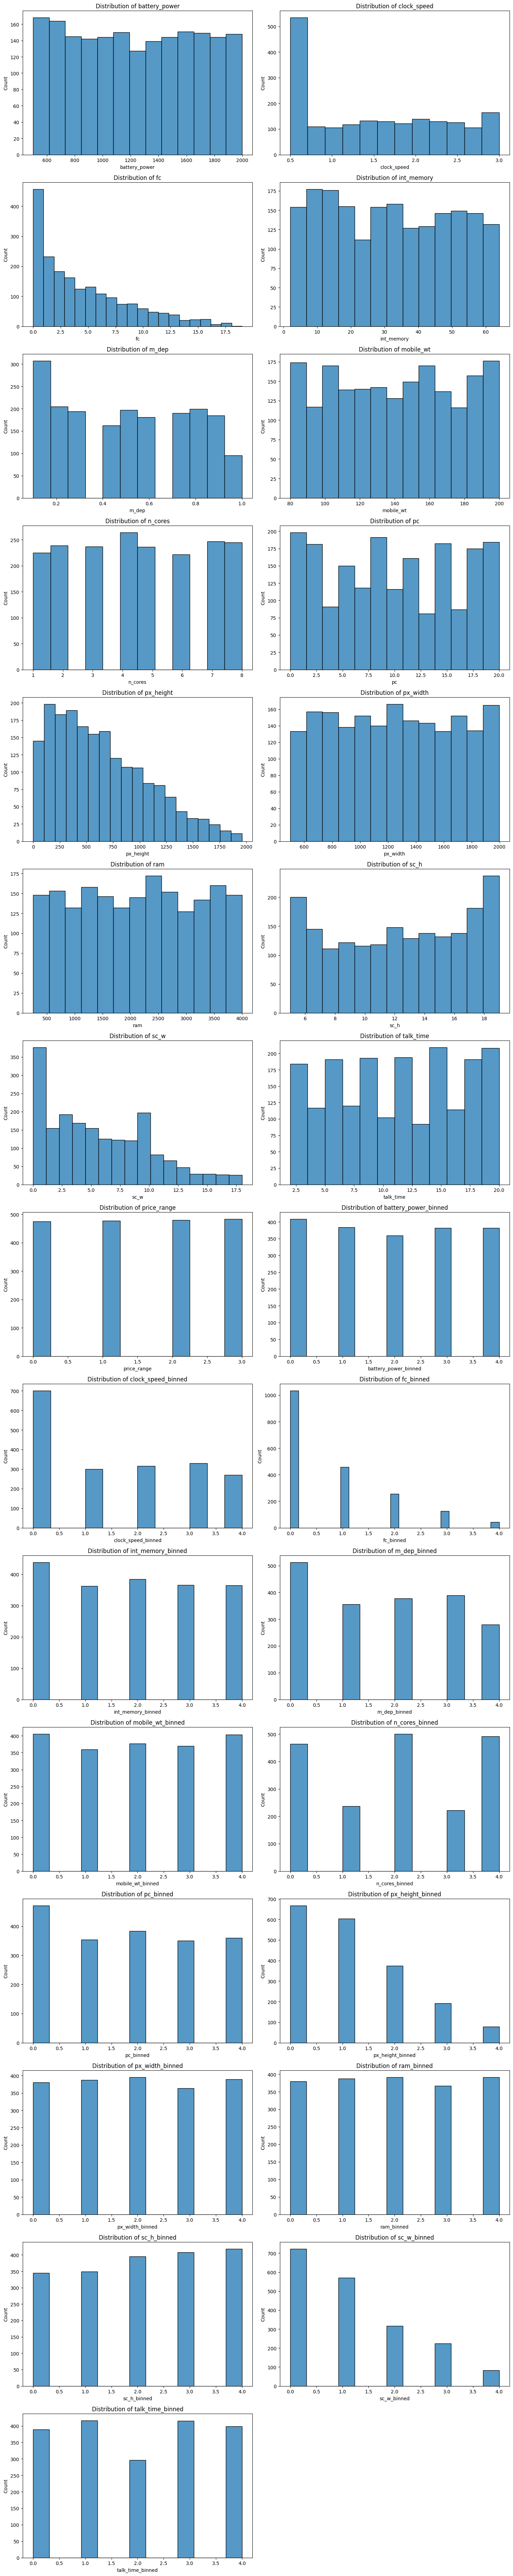

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# EDA for numerical data
numerical_columns = cleaned_train_data.select_dtypes(include=['int64', 'float64']).columns

# Set up the figure layout for numerical data
num_plots = len(numerical_columns)
num_rows = num_plots // 2 + num_plots % 2  # Calculate number of rows
plt.figure(figsize=(15, 5 * num_rows))

# Plot numerical data
for i, column in enumerate(numerical_columns, start=1):
    plt.subplot(num_rows, 2, i)
    sns.histplot(cleaned_train_data[column])
    plt.title(f'Distribution of {column}')

# Adjust layout and show the plots for numerical data
plt.tight_layout()
plt.show()


In [ ]:
# Convert boolean columns to categorical type
c_cleaned_train_data=cleaned_train_data.copy()
c_cleaned_train_data['blue'] = cleaned_train_data['blue'].astype('category')
c_cleaned_train_data['touch_screen'] = cleaned_train_data['touch_screen'].astype('category')
c_cleaned_train_data['wifi'] = cleaned_train_data['wifi'].astype('category')

<ipython-input-28-d3be530ec3c0>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=cleaned_train_data, ax=axes[i], palette='pastel')  # Use a pastel color palette
<ipython-input-28-d3be530ec3c0>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=cleaned_train_data, ax=axes[i], palette='pastel')  # Use a pastel color palette
<ipython-input-28-d3be530ec3c0>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=cleaned_train_data, ax=axes[i], palette='pastel')  # Use a pastel color palette


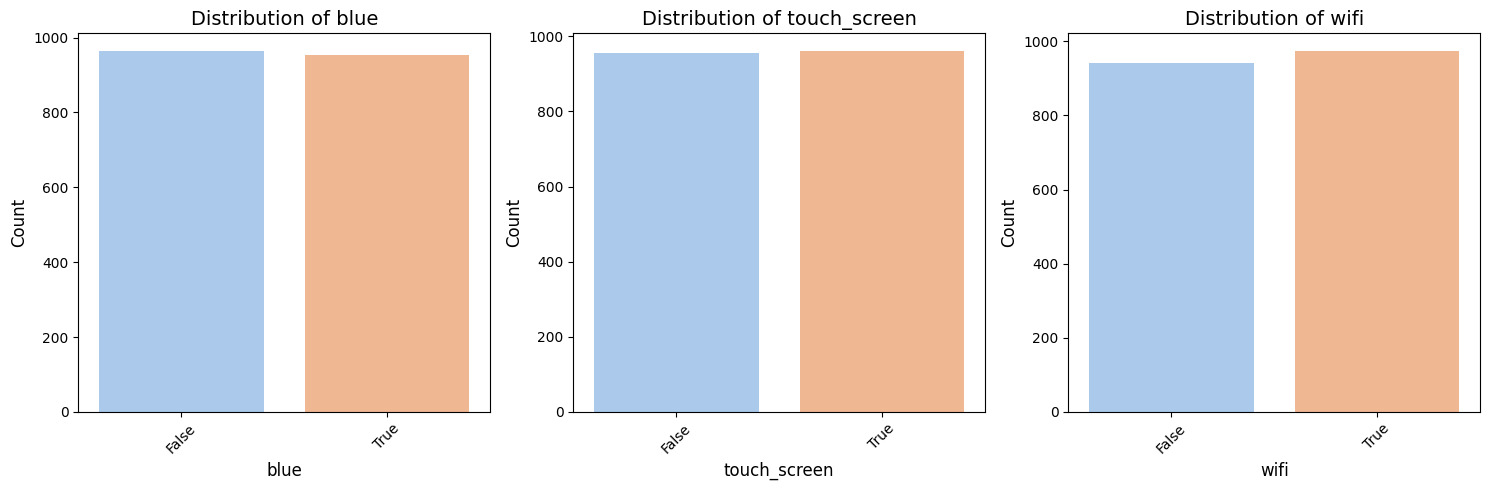

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert boolean columns to categorical type
cleaned_train_data['blue'] = cleaned_train_data['blue'].astype('category')
cleaned_train_data['touch_screen'] = cleaned_train_data['touch_screen'].astype('category')
cleaned_train_data['wifi'] = cleaned_train_data['wifi'].astype('category')

# Select categorical columns
categorical_columns = cleaned_train_data.select_dtypes(include=['category']).columns

# Check if there are any categorical columns
if len(categorical_columns) == 0:
    print("No categorical columns found in the dataset.")
else:
    # Set up the figure layout for categorical EDA
    num_plots_per_row = 3
    num_plots = len(categorical_columns)
    num_rows = (num_plots + num_plots_per_row - 1) // num_plots_per_row

    # Create the figure and axes
    fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    # Iterate over categorical columns and create EDA plots
    for i, column in enumerate(categorical_columns):
        sns.countplot(x=column, data=cleaned_train_data, ax=axes[i], palette='pastel')  # Use a pastel color palette
        axes[i].set_title(f'Distribution of {column}', fontsize=14)  # Increase title font size
        axes[i].set_xlabel(column, fontsize=12)  # Set x-axis label
        axes[i].set_ylabel('Count', fontsize=12)  # Set y-axis label
        axes[i].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels for better readability

    # Hide empty subplots
    for j in range(num_plots, num_rows * num_plots_per_row):
        axes[j].axis('off')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()


In [ ]:
# Check class distribution
class_distribution = cleaned_train_data['price_range'].value_counts()
print("Class Distribution:")
print(class_distribution)

# Check for class imbalance
if len(class_distribution) > 1:
    minority_class_percentage = class_distribution.min() / class_distribution.sum() * 100
    if minority_class_percentage < 10:
        print("Warning: Data is imbalanced. Consider addressing class imbalance.")


Class Distribution:
price_range
3    483
2    480
1    477
0    475
Name: count, dtype: int64


In [ ]:
'''       # from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a Ridge regression model
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)

# Evaluate the model
train_error = mean_squared_error(y_train, ridge_model.predict(X_train))
test_error = mean_squared_error(y_test, ridge_model.predict(X_test))
print("Train Error:", train_error)
print("Test Error:", test_error)

# Check for overfitting
if test_error > train_error:
    print("Warning: Model may be overfitting. Consider penalizing large coefficients.") */        '''


'       # from sklearn.linear_model import Ridge\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import mean_squared_error\n\n# Split data into train and test sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Fit a Ridge regression model\nridge_model = Ridge(alpha=0.1)\nridge_model.fit(X_train, y_train)\n\n# Evaluate the model\ntrain_error = mean_squared_error(y_train, ridge_model.predict(X_train))\ntest_error = mean_squared_error(y_test, ridge_model.predict(X_test))\nprint("Train Error:", train_error)\nprint("Test Error:", test_error)\n\n# Check for overfitting\nif test_error > train_error:\n    print("Warning: Model may be overfitting. Consider penalizing large coefficients.") */        '

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Min-Max Scaling
minmax_scaler = MinMaxScaler()
X_minmax_scaled = minmax_scaler.fit_transform(X)

# Check for feature scaling
# You can visually inspect the scaled features or check their statistics
print("Standardized Features:")
print(X_scaled)
print("MinMax Scaled Features:")
print(X_minmax_scaled)


Standardized Features:
[[-0.90252412 -0.99427228  0.83622668 ... -0.78722826 -0.12879123
   1.37993835]
 [-0.49554977  1.00576072 -1.24809761 ...  1.34608606 -0.98220024
  -0.70028884]
 [-1.53685846  1.00576072 -1.24809761 ... -0.07612349 -0.98220024
  -0.70028884]
 ...
 [ 1.52795402 -0.99427228 -0.75766837 ... -0.78722826 -0.98220024
  -1.3936979 ]
 [ 0.62078772 -0.99427228 -0.75766837 ...  1.34608606  0.72461778
   1.37993835]
 [-1.65735924  1.00576072  0.59101206 ...  1.34608606 -0.12879123
  -1.3936979 ]]
MinMax Scaled Features:
[[0.22778891 0.         0.68       ... 0.25       0.25       1.        ]
 [0.34736139 1.         0.         ... 1.         0.         0.25      ]
 [0.04141617 1.         0.         ... 0.5        0.         0.25      ]
 ...
 [0.94188377 0.         0.16       ... 0.25       0.         0.        ]
 [0.6753507  0.         0.16       ... 1.         0.5        1.        ]
 [0.00601202 1.         0.6        ... 1.         0.25       0.        ]]


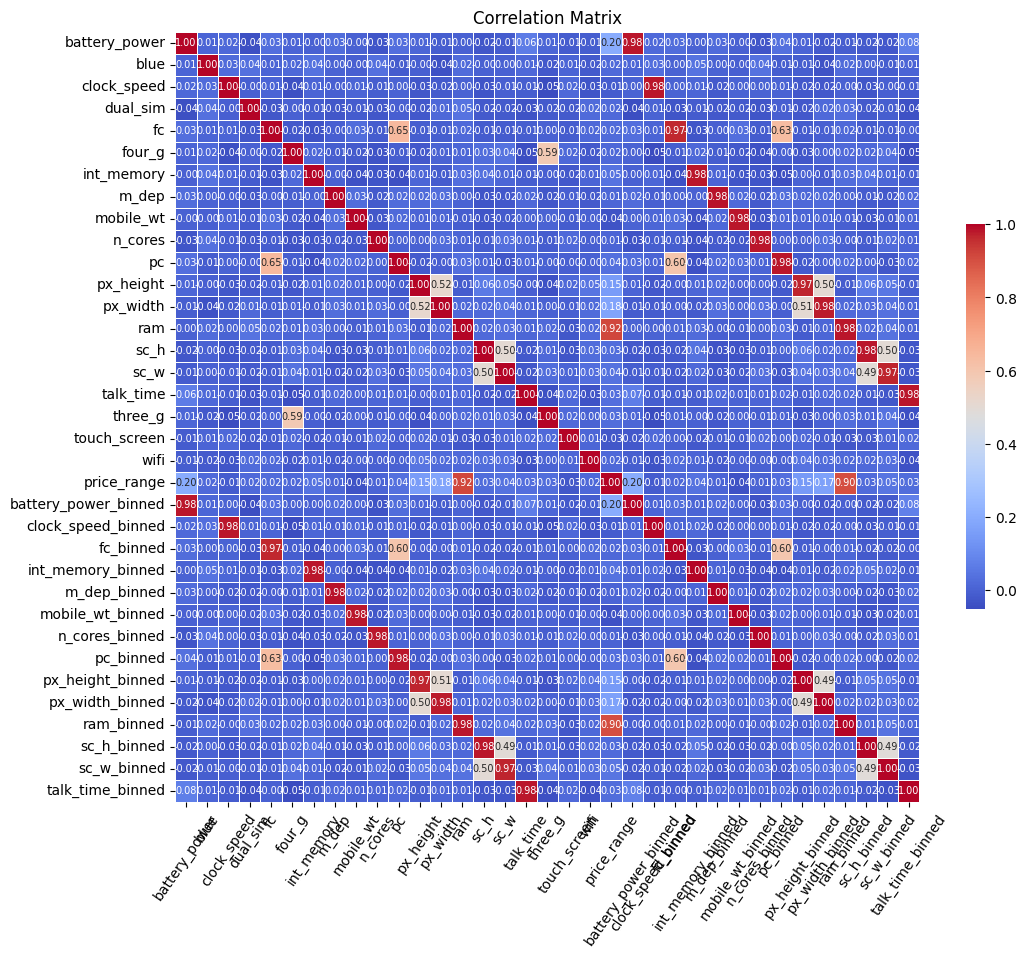

Highly Correlated Features:
{'clock_speed_binned', 'm_dep_binned', 'fc_binned', 'px_height_binned', 'sc_w_binned', 'px_width_binned', 'pc_binned', 'sc_h_binned', 'ram_binned', 'n_cores_binned', 'battery_power_binned', 'int_memory_binned', 'talk_time_binned', 'price_range', 'mobile_wt_binned'}


In [ ]:
# Calculate correlation matrix
correlation_matrix = cleaned_train_data.corr()

# Visualize correlation matrix with improved readability
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"size": 7.0})
plt.xticks(rotation=55)
plt.title("Correlation Matrix")
plt.show()

# Check for highly correlated features
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)
print("Highly Correlated Features:")
print(highly_correlated_features)


Explained Variance Ratio:
[0.09638767 0.09185162 0.08378959 0.06341657 0.0608926  0.06042377
 0.05907191 0.05791542 0.05710374 0.05479664]


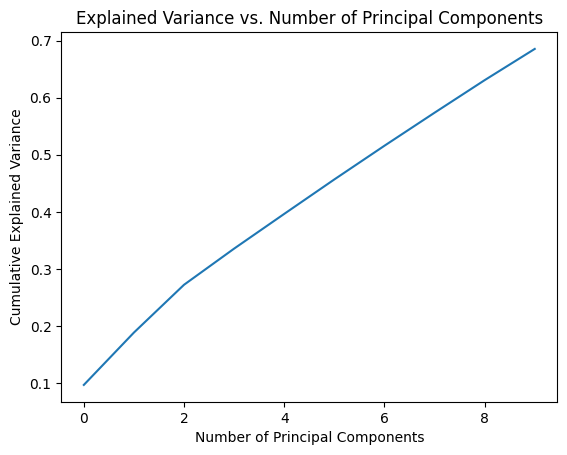

In [ ]:
from sklearn.decomposition import PCA

# Instantiate PCA with desired number of components
pca = PCA(n_components=10)  # Choose the number of principal components

# Fit PCA on the standardized features
principal_components = pca.fit_transform(X_scaled)

# Explain the variance ratio captured by each principal component
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:")
print(explained_variance_ratio)

# Visualize the cumulative explained variance
import numpy as np
import matplotlib.pyplot as plt

cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(cumulative_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.show()


The explained variance ratio tells us how much of the total variability in the original dataset each principal component explains. For instance, the first principal component explains about 9.64% of the variance, while the second explains 9.19%, and so forth.

This information helps us gauge how well each principal component summarizes the data. Generally, we want to keep as much information as possible while reducing the dataset's complexity. The cumulative explained variance plot gives us a clear picture of how adding more principal components contributes to capturing the overall variance. It helps us decide how many components to retain for our analysis.

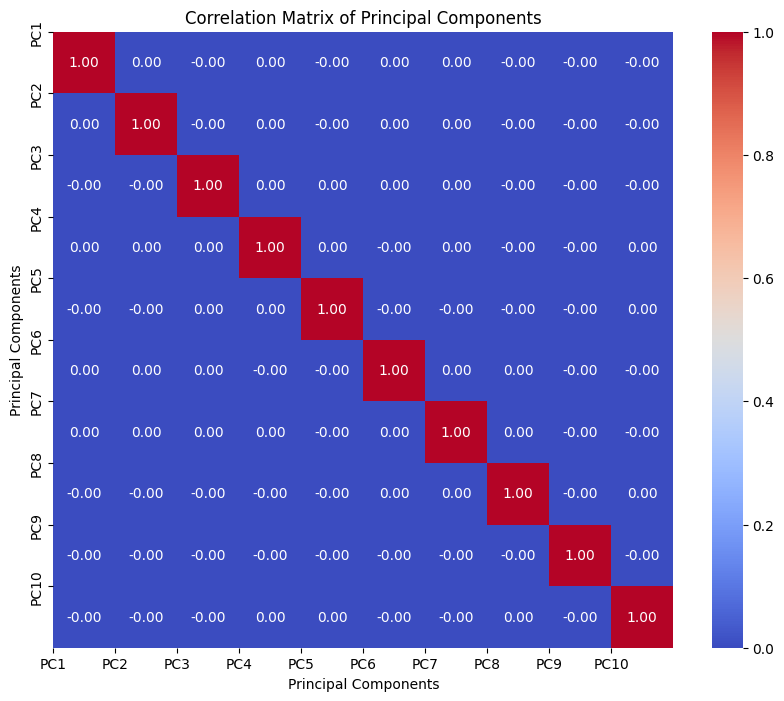

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix of the principal components
pca_corr_matrix = pd.DataFrame(principal_components).corr()

# Identify highly correlated principal components
threshold = 0.8
highly_correlated_pcs = set()
for i in range(len(pca_corr_matrix.columns)):
    for j in range(i):
        if abs(pca_corr_matrix.iloc[i, j]) > threshold:
            pc1 = pca_corr_matrix.columns[i]
            pc2 = pca_corr_matrix.columns[j]
            highly_correlated_pcs.add((pc1, pc2))

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(pca_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Principal Components")
plt.xlabel("Principal Components")
plt.ylabel("Principal Components")

# Set tick labels for both axes
plt.xticks(ticks=range(len(pca_corr_matrix.columns)), labels=['PC' + str(i+1) for i in range(len(pca_corr_matrix.columns))])
plt.yticks(ticks=range(len(pca_corr_matrix.columns)), labels=['PC' + str(i+1) for i in range(len(pca_corr_matrix.columns))])

plt.show()


In [ ]:
pc_correlation_matrix = pd.DataFrame(data=principal_components).corr()

# Identify highly correlated principal components
threshold = 0.8
highly_correlated_pcs = set()
for i in range(len(pc_correlation_matrix.columns)):
    for j in range(i):
        if abs(pc_correlation_matrix.iloc[i, j]) > threshold:
            pc1 = pc_correlation_matrix.columns[i]
            pc2 = pc_correlation_matrix.columns[j]
            highly_correlated_pcs.add((pc1, pc2))

# Print highly correlated principal components
print("Highly Correlated PCs:")
for pair in highly_correlated_pcs:
    print(pair)

Highly Correlated PCs:


## **Dimensionality Reduction with PCA:**

Dimensionality reduction techniques like Principal Component Analysis (PCA) are used to reduce the number of features in a dataset while preserving the most important information. This is beneficial for several reasons:

**Curse of Dimensionality:** High-dimensional data often suffers from the curse of dimensionality, where the volume of the feature space increases exponentially with the number of features. This can lead to overfitting and increased computational complexity.

**Multicollinearity:** High-dimensional datasets may contain highly correlated features, leading to multicollinearity issues in regression models. PCA can help mitigate multicollinearity by transforming the original features into a set of linearly uncorrelated variables (principal components).

**Visualization:** PCA can also be used for data visualization by projecting high-dimensional data onto a lower-dimensional subspace, making it easier to explore and interpret.

# **Feature Selection**

### **Univariate Feature Selection (using chi-square test, ANOVA, or mutual information)**

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split

# Assuming your data is stored in a DataFrame named 'data'
X = cleaned_train_data.drop(columns=['price_range'])  # Features
y = cleaned_train_data['price_range']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SelectKBest with chi-square test
selector_chi2 = SelectKBest(score_func=chi2, k=10)
X_selected_chi2 = selector_chi2.fit_transform(X_train, y_train)
selected_features_chi2 = X.columns[selector_chi2.get_support(indices=True)]

# SelectKBest with ANOVA
selector_anova = SelectKBest(score_func=f_classif, k=10)
X_selected_anova = selector_anova.fit_transform(X_train, y_train)
selected_features_anova = X.columns[selector_anova.get_support(indices=True)]

# SelectKBest with mutual information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=10)
X_selected_mi = selector_mi.fit_transform(X_train, y_train)
selected_features_mi = X.columns[selector_mi.get_support(indices=True)]

print("Selected Features (chi-square):", selected_features_chi2)
print("Selected Features (ANOVA):", selected_features_anova)
print("Selected Features (mutual information):", selected_features_mi)

Selected Features (chi-square): Index(['battery_power', 'int_memory', 'mobile_wt', 'px_height', 'px_width',
       'ram', 'battery_power_binned', 'px_height_binned', 'px_width_binned',
       'ram_binned'],
      dtype='object')
Selected Features (ANOVA): Index(['battery_power', 'mobile_wt', 'px_height', 'px_width', 'ram',
       'battery_power_binned', 'px_height_binned', 'px_width_binned',
       'ram_binned', 'sc_w_binned'],
      dtype='object')
Selected Features (mutual information): Index(['battery_power', 'blue', 'm_dep', 'px_width', 'ram', 'sc_h', 'sc_w',
       'px_height_binned', 'px_width_binned', 'ram_binned'],
      dtype='object')


### **Feature Importance with Tree-Based Models**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Fit a RandomForestClassifier to the data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance scores
feature_importances = rf.feature_importances_

# Sort feature importance scores in descending order and get corresponding feature names
indices = feature_importances.argsort()[::-1]
selected_features_rf = X.columns[indices[:10]]  # Select top 10 features

print("Selected Features (Random Forest):", selected_features_rf)


Selected Features (Random Forest): Index(['ram', 'ram_binned', 'battery_power', 'px_width', 'px_height',
       'mobile_wt', 'battery_power_binned', 'int_memory', 'talk_time', 'pc'],
      dtype='object')


### **Recursive Feature Elimination (RFE)**

In [ ]:


from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Instantiate StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data
X_test_scaled = scaler.transform(X_test)

# Instantiate LogisticRegression
logistic_regression = LogisticRegression(max_iter=10000, random_state=42)

# Train the logistic regression model on the scaled data
logistic_regression.fit(X_train_scaled, y_train)

# Fit RFE with logistic regression estimator
estimator = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(estimator, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X.columns[rfe.support_]

print("Selected Features (RFE):", selected_features_rfe)


Selected Features (RFE): Index(['clock_speed', 'four_g', 'm_dep', 'wifi', 'battery_power_binned',
       'clock_speed_binned', 'mobile_wt_binned', 'px_height_binned',
       'px_width_binned', 'ram_binned'],
      dtype='object')


**We can now select the selected features from the any of above appropriate methods.**

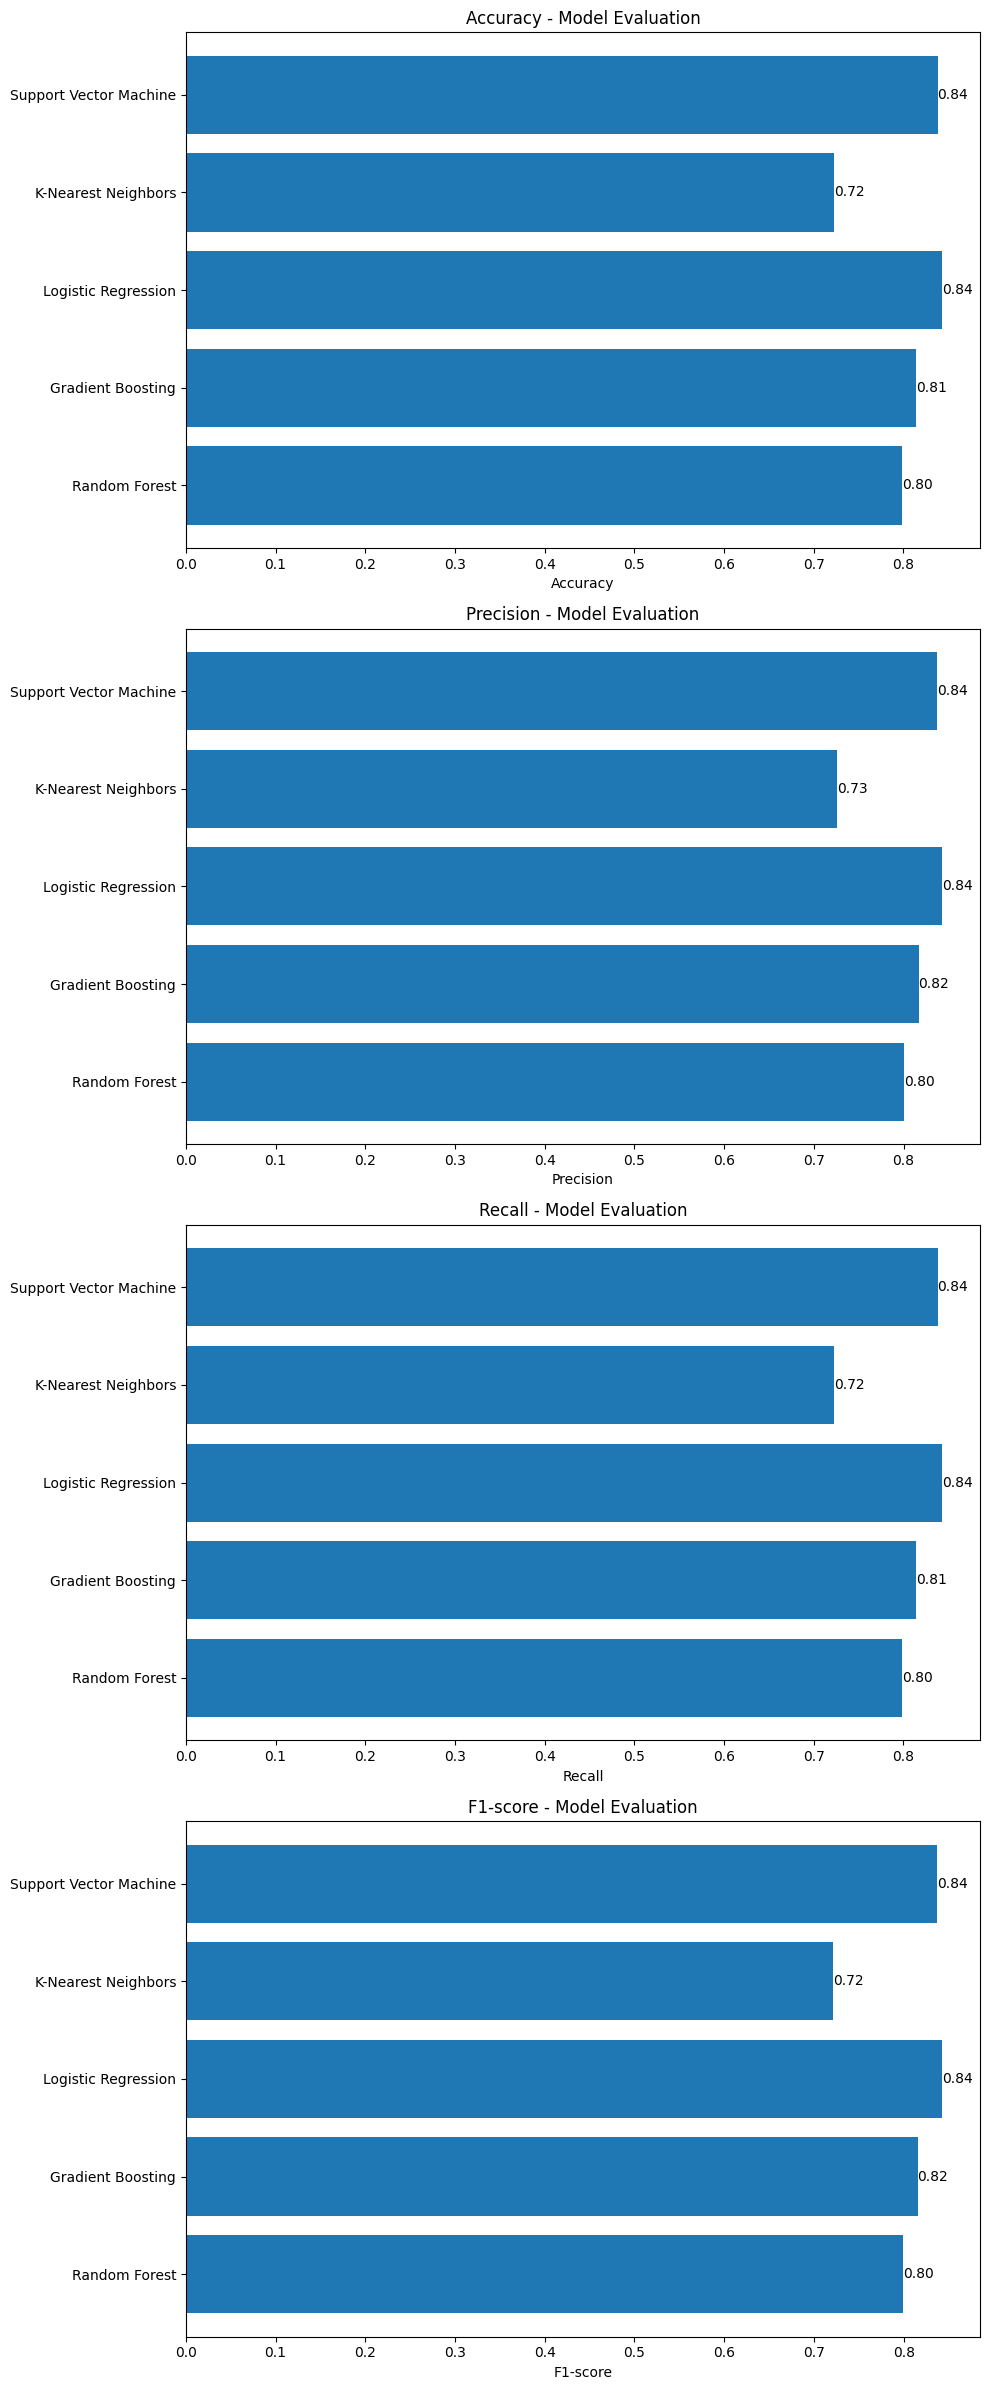

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'cleaned_train_data'
X = cleaned_train_data[selected_features_rfe]  # Features
y = cleaned_train_data['price_range']  # Target variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(kernel='linear', random_state=42)
}

# Define evaluation metrics and corresponding functions with appropriate averaging strategy
metrics = {
    "Accuracy": accuracy_score,
    "Precision": lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
    "Recall": lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted'),
    "F1-score": lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted')
}

# Initialize metric scores dictionary
metric_scores = {metric: {model_name: [] for model_name in models} for metric in metrics}

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    for metric_name, metric_func in metrics.items():
        metric_scores[metric_name][model_name].append(metric_func(y_test, y_pred))

# Plot evaluation metrics separately as horizontal histograms
fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 6 * len(metrics)))

for i, (metric_name, model_scores) in enumerate(metric_scores.items()):
    ax = axs[i]
    model_names = list(model_scores.keys())
    scores = [list(model_scores[model_name]) for model_name in model_names]
    bars = ax.barh(model_names, [score[0] for score in scores], align='center')  # Flatten the scores list
    ax.set_xlabel(metric_name)
    ax.set_title(f'{metric_name} - Model Evaluation')

    # Annotate bars with score values
    for bar, score in zip(bars, scores):
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score[0]:.2f}',
                va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()


# **ROC-AUC Curve**

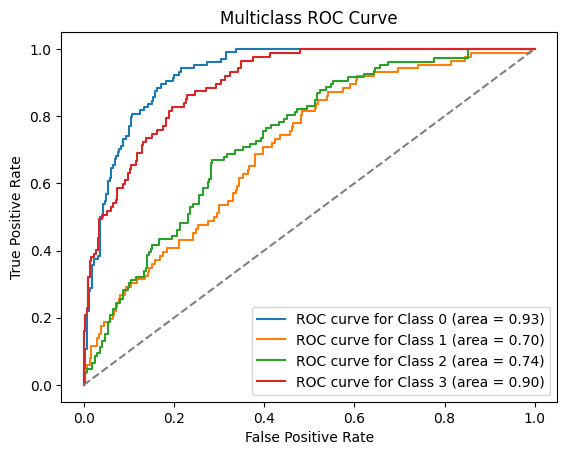

ROC-AUC for Class 0: 0.93
ROC-AUC for Class 1: 0.70
ROC-AUC for Class 2: 0.74
ROC-AUC for Class 3: 0.90


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming 'cleaned_train_data' is your DataFrame and 'selected_features_rfe' are your selected features
X = cleaned_train_data[selected_features_rfe]  # Features
y = cleaned_train_data['price_range']  # Target variable

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Binarize the labels
y_train_bin = label_binarize(y_train, classes=[0, 1, 2, 3])

# Use OneVsRestClassifier to handle multiclass ROC-AUC
ovr_classifier = OneVsRestClassifier(MultinomialNB(alpha=0.3))

# Fit the model
ovr_classifier.fit(x_train, y_train)

# Predict probabilities
y_prob = ovr_classifier.predict_proba(x_test)

# Compute ROC-AUC score for each class
roc_auc = []
for i in range(y_train_bin.shape[1]):
    roc_auc_class = roc_auc_score(y_test == i, y_prob[:, i])
    roc_auc.append(roc_auc_class)
    fpr, tpr, _ = roc_curve(y_test == i, y_prob[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve for Class {i} (area = {roc_auc_class:.2f})')

# Plot the ROC curve
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend()
plt.show()

# Display ROC-AUC score for each class
for i, auc in enumerate(roc_auc):
    print(f'ROC-AUC for Class {i}: {auc:.2f}')


Fine-tuning Random Forest...
Fine-tuning Gradient Boosting...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fine-tuning Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:11

Fine-tuning K-Nearest Neighbors...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fine-tuning Support Vector Machine...

Accuracy:
Random Forest: 0.82
Gradient Boosting: 0.83
Logistic Regression: 0.84
K-Nearest Neighbors: 0.72
Support Vector Machine: 0.84

Precision:
Random Forest: 0.82
Gradient Boosting: 0.83
Logistic Regression: 0.84
K-Nearest Neighbors: 0.72
Support Vector Machine: 0.84

Recall:
Random Forest: 0.82
Gradient Boosting: 0.83
Logistic Regression: 0.84
K-Nearest Neighbors: 0.72
Support Vector Machine: 0.84

F1-score:
Random Forest: 0.82
Gradient Boosting: 0.83
Logistic Regression: 0.84
K-Nearest Neighbors: 0.72
Support Vector Machine: 0.84


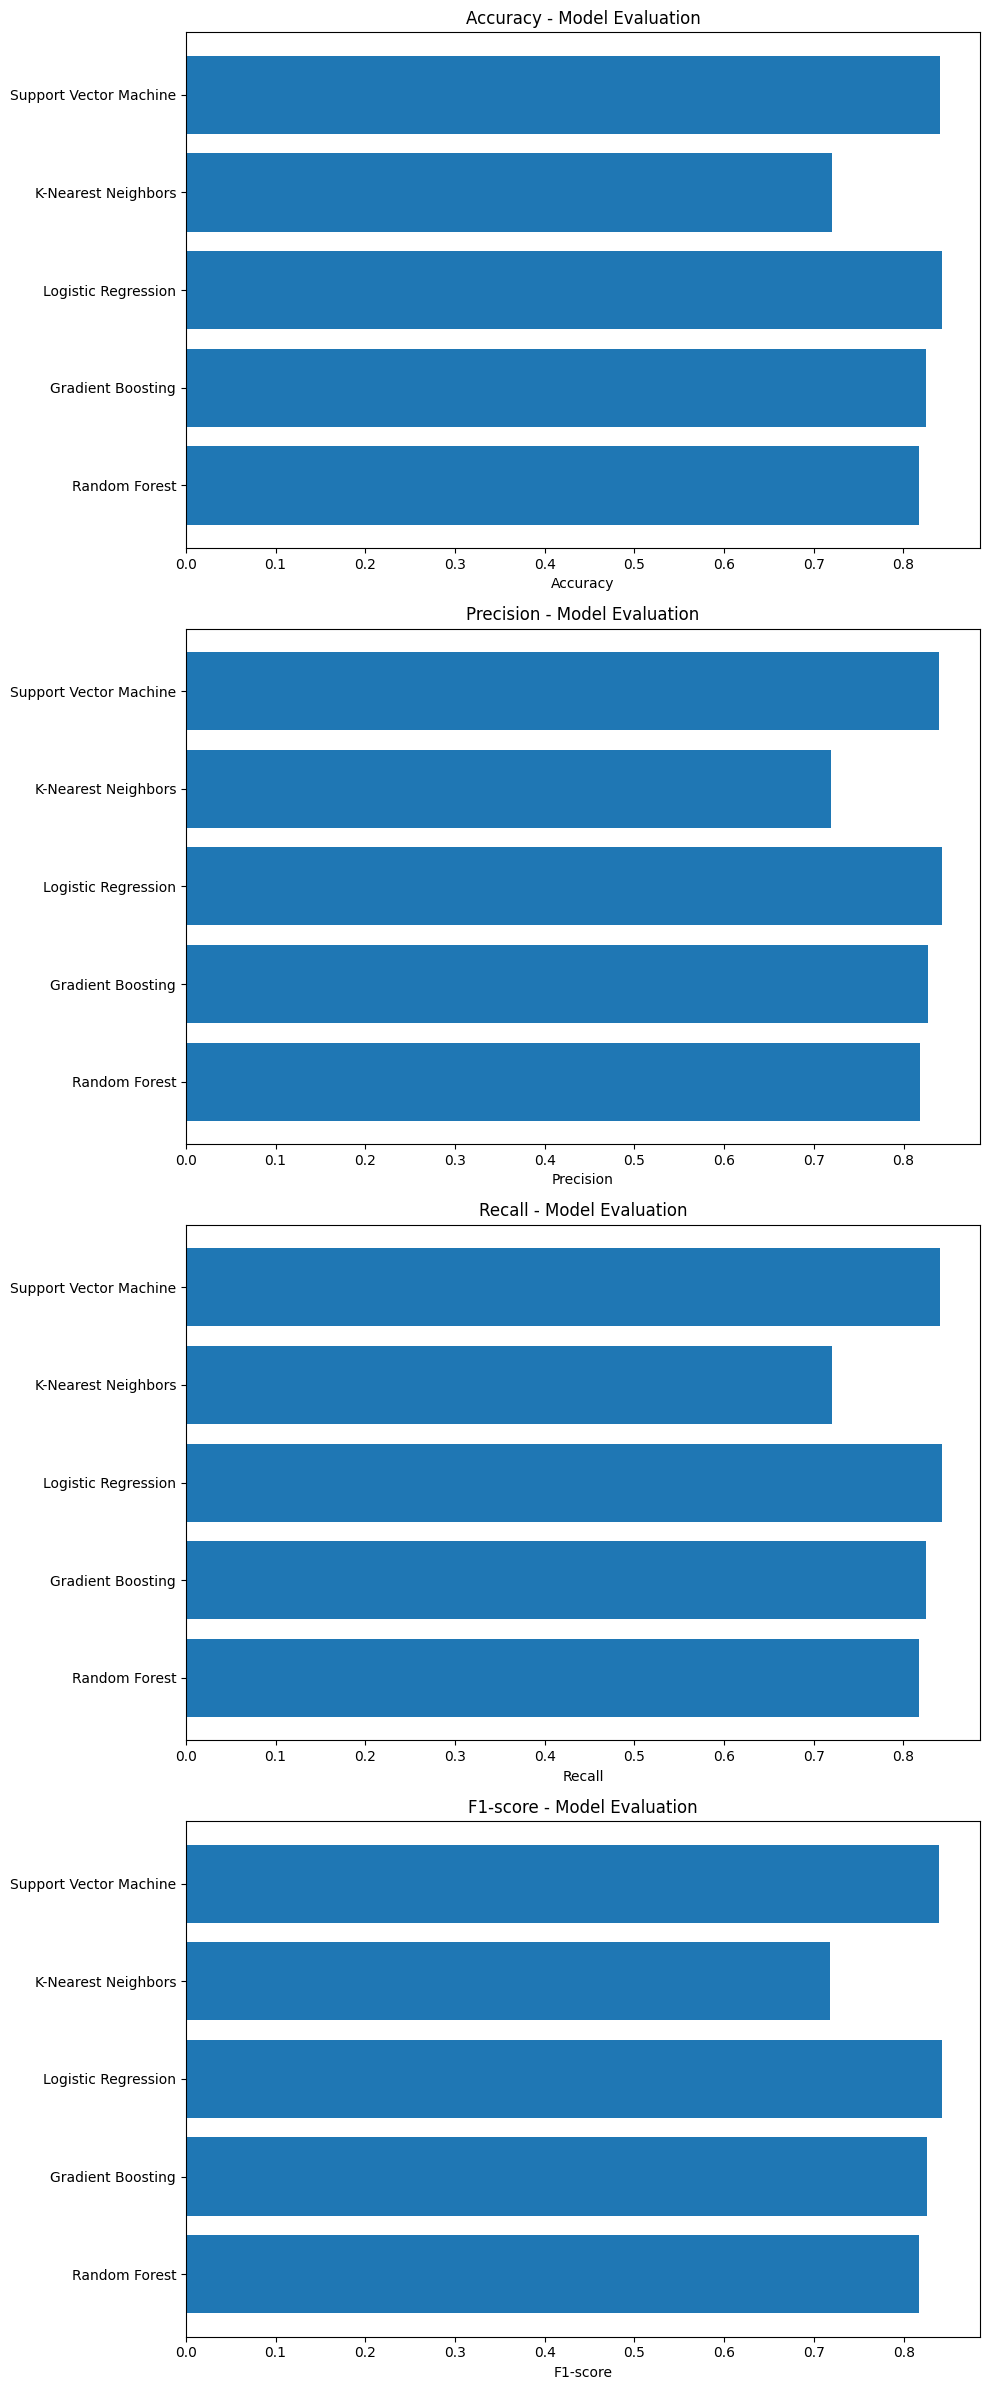


Best hyperparameters:
Random Forest: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Gradient Boosting: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Logistic Regression: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define hyperparameter grids with corrected parameters for each algorithm
param_grids = {
    "Random Forest": {
        'n_estimators': [50, 100],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "Gradient Boosting": {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    "Logistic Regression": {
        'C': np.logspace(-3, 3, 7),  # Use a logarithmic scale for C
        'penalty': ['l2', 'none']  # Set penalty to 'none' explicitly
    },
    "K-Nearest Neighbors": {
        'n_neighbors': [3, 5],
        'weights': ['uniform', 'distance']
    },
    "Support Vector Machine": {
        'C': np.logspace(-3, 3, 7),  # Use a logarithmic scale for C
        'kernel': ['linear', 'rbf']
    }
}


# Loop through models
for model_name, model in models.items():
    print(f"Fine-tuning {model_name}...")
    # Initialize RandomizedSearchCV with reduced parameter grid
    randomized_search = RandomizedSearchCV(model, param_distributions=param_grids[model_name],
                                           scoring='accuracy', cv=5, n_iter=10)  # Adjust n_iter as needed

    # Fit the model
    randomized_search.fit(X_train, y_train)

    # Get the best estimator
    best_estimator = randomized_search.best_estimator_
    best_estimators[model_name] = best_estimator

    # Predict on the test set
    y_pred = best_estimator.predict(X_test)

    # Compute evaluation metrics
    for metric_name, metric_func in metrics.items():
        metric_score = metric_func(y_test, y_pred)
        metric_scores[metric_name][model_name] = metric_score

# Display evaluation metrics for all models
for metric_name, model_scores in metric_scores.items():
    print(f"\n{metric_name}:")
    for model_name, score in model_scores.items():
        print(f"{model_name}: {score:.2f}")

# Plot the evaluation metrics for all models
fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 6 * len(metrics)))

for i, (metric_name, model_scores) in enumerate(metric_scores.items()):
    ax = axs[i]
    model_names = list(model_scores.keys())
    scores = list(model_scores.values())
    ax.barh(model_names, scores, align='center')
    ax.set_xlabel(metric_name)
    ax.set_title(f'{metric_name} - Model Evaluation')

plt.tight_layout()
plt.show()

# Display best hyperparameters for all models
print("\nBest hyperparameters:")
for model_name, best_estimator in best_estimators.items():
    print(f"{model_name}: {best_estimator.get_params()}")


This code segment aims to improve the performance of each machine learning model by finding the best hyperparameters through randomized search cross-validation. Here is how it works:

First, it imports the necessary libraries - RandomizedSearchCV from sklearn.model_selection and numpy for parameter grids.

Then, it defines hyperparameter grids (param_grids) for each model with corrected parameters.

Next, it loops through each model, initializes RandomizedSearchCV with the respective parameter grid, and performs hyperparameter tuning.

For each model, it selects the best estimator and computes evaluation metrics on the test set.

It then plots the evaluation metrics for all models using horizontal histograms.

Finally, it displays the best hyperparameters for all models, which were found through the randomized search cross-validation process.

This code segment is a great tool for improving machine learning models' performance. By finding the best hyperparameters and evaluating the performance of each tuned model on the test set, it provides a reliable comparison between the models.

# **Cross-Validation**

In [ ]:
# Define valid classification scoring metrics
classification_scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

# Initialize a dictionary to store cross-validation scores for each metric
cv_scores = {metric: {model_name: [] for model_name in models} for metric in classification_scoring}

# Perform cross-validation for each model and metric
for model_name, model in models.items():
    for metric_name in classification_scoring:
        # Initialize a KFold object
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        # Perform cross-validation
        scores = cross_val_score(model, X, y, cv=kf, scoring=metric_name)
        # Store the cross-validation scores
        cv_scores[metric_name][model_name] = scores

# Print the mean and standard deviation of cross-validation scores for each model and metric
for metric_name, model_scores in cv_scores.items():
    print(f"Metric: {metric_name}")
    for model_name, scores in model_scores.items():
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        print(f"{model_name}: Mean = {mean_score:.3f}, Std = {std_score:.3f}")
    print()


Metric: accuracy
Random Forest: Mean = 0.810, Std = 0.005
Gradient Boosting: Mean = 0.815, Std = 0.006
Logistic Regression: Mean = 0.843, Std = 0.012
K-Nearest Neighbors: Mean = 0.705, Std = 0.023
Support Vector Machine: Mean = 0.839, Std = 0.011

Metric: precision_weighted
Random Forest: Mean = 0.812, Std = 0.006
Gradient Boosting: Mean = 0.817, Std = 0.005
Logistic Regression: Mean = 0.844, Std = 0.013
K-Nearest Neighbors: Mean = 0.710, Std = 0.023
Support Vector Machine: Mean = 0.840, Std = 0.011

Metric: recall_weighted
Random Forest: Mean = 0.810, Std = 0.005
Gradient Boosting: Mean = 0.815, Std = 0.006
Logistic Regression: Mean = 0.843, Std = 0.012
K-Nearest Neighbors: Mean = 0.705, Std = 0.023
Support Vector Machine: Mean = 0.839, Std = 0.011

Metric: f1_weighted
Random Forest: Mean = 0.810, Std = 0.005
Gradient Boosting: Mean = 0.815, Std = 0.005
Logistic Regression: Mean = 0.843, Std = 0.013
K-Nearest Neighbors: Mean = 0.706, Std = 0.023
Support Vector Machine: Mean = 0.839, S

This code segment defines a set of valid classification scoring metrics, such as accuracy, precision, recall, and F1-score. Then, it initializes a dictionary called cv_scores to store the cross-validation scores for each metric and each model.

It performs cross-validation for each model and metric using K-Fold cross-validation, where num_folds determines the number of folds used.

For each model and metric combination, it calculates the mean and standard deviation of the cross-validation scores and prints out the results.

In simpler terms, it evaluates each machine learning model using different evaluation metrics like accuracy, precision, recall, and F1-score. Then, it performs cross-validation to ensure the models' performance is consistent across different subsets of the data. Finally, it prints out the average performance metrics for each model.

### **StratifiedKFold cross-validation technique**

StratifiedKFold is a variation of KFold that ensures each fold's class distribution is similar to the original dataset.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

# Define the number of folds for cross-validation
num_folds = 5  # You can adjust this as needed

# Define valid classification scoring metrics
classification_scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

# Initialize a dictionary to store cross-validation scores for each metric
cv_scores = {metric: {model_name: [] for model_name in models} for metric in classification_scoring}

# Perform cross-validation for each model and metric using StratifiedKFold
for model_name, model in models.items():
    for metric_name in classification_scoring:
        # Initialize a StratifiedKFold object
        skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
        # Perform cross-validation
        scores = cross_val_score(model, X, y, cv=skf, scoring=metric_name, n_jobs=-1)
        # Store the cross-validation scores
        cv_scores[metric_name][model_name] = scores

# Print the mean and standard deviation of cross-validation scores for each model and metric
for metric_name, model_scores in cv_scores.items():
    print(f"Metric: {metric_name}")
    for model_name, scores in model_scores.items():
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        print(f"{model_name}: Mean = {mean_score:.3f}, Std = {std_score:.3f}")
    print()


Metric: accuracy
Random Forest: Mean = 0.799, Std = 0.017
Gradient Boosting: Mean = 0.810, Std = 0.024
Logistic Regression: Mean = 0.839, Std = 0.027
K-Nearest Neighbors: Mean = 0.722, Std = 0.029
Support Vector Machine: Mean = 0.838, Std = 0.028

Metric: precision_weighted
Random Forest: Mean = 0.799, Std = 0.016
Gradient Boosting: Mean = 0.812, Std = 0.025
Logistic Regression: Mean = 0.841, Std = 0.026
K-Nearest Neighbors: Mean = 0.727, Std = 0.031
Support Vector Machine: Mean = 0.839, Std = 0.027

Metric: recall_weighted
Random Forest: Mean = 0.799, Std = 0.017
Gradient Boosting: Mean = 0.810, Std = 0.024
Logistic Regression: Mean = 0.839, Std = 0.027
K-Nearest Neighbors: Mean = 0.722, Std = 0.029
Support Vector Machine: Mean = 0.838, Std = 0.028

Metric: f1_weighted
Random Forest: Mean = 0.799, Std = 0.016
Gradient Boosting: Mean = 0.810, Std = 0.024
Logistic Regression: Mean = 0.839, Std = 0.027
K-Nearest Neighbors: Mean = 0.723, Std = 0.030
Support Vector Machine: Mean = 0.838, S

This code segment is similar to the previous one, but it uses StratifiedKFold instead of KFold for cross-validation. StratifiedKFold is a variation of k-fold cross-validation that ensures each fold has the same proportion of class labels as the entire dataset.

Here's what this code does:

1. It imports the necessary libraries and defines the number of folds for cross-validation (num_folds).
2. It defines a list of valid classification scoring metrics (classification_scoring).
3. It initializes a dictionary called cv_scores to store cross-validation scores for each metric and each model.
4. It performs cross-validation for each model and metric using StratifiedKFold.
5. For each model and metric combination, it calculates the mean and standard deviation of the cross-validation scores and prints out the results.

Overall, this code evaluates each machine learning model using different evaluation metrics and ensures the models' performance consistency across different subsets of the data using stratified k-fold cross-validation. Then, it prints out the average performance metrics for each model.

#**Step-by-step guide to deploying a machine learning model for real-time predictions**

# **Step 1: Train and Serialize the Model**
### First, train your machine learning model using your dataset. Once trained, serialize the model using joblib and save it to disk.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import joblib

# Load sample dataset (replace this with your dataset)
iris = load_iris()
X, y = iris.data, iris.target

# Train a Random Forest classifier
model = RandomForestClassifier()
model.fit(X, y)

# Serialize and save the trained model
joblib.dump(model, 'model.pkl')

# **Step 2: Create a Flask Web Application**
### Next, create a Flask web application with an endpoint for making predictions.

In [ ]:
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)

# Load the serialized model
model = joblib.load('model.pkl')

# Define the prediction endpoint
@app.route('/predict', methods=['POST'])
def predict():
    # Get input data from the request
    data = request.json

    # Perform prediction using the loaded model
    prediction = model.predict([data['features']])[0]

    # Return the prediction as JSON
    return jsonify({'prediction': prediction})

# Run the Flask application
if __name__ == '__main__':
    app.run(debug=True)


# **Step 3: Start the Flask Server**
### Start the Flask server to expose your model as an API endpoint.



In [ ]:
$ python app.py

# **Step 4: Make Predictions via API**
### Now, you can make predictions by sending POST requests to the /predict endpoint with input data in JSON format.

In [ ]:
import requests

# Define input data for prediction
data = {'features': [5.1, 3.5, 1.4, 0.2]}  # Example input data (replace with your own)

# Make a POST request to the Flask server
response = requests.post('http://localhost:5000/predict', json=data)

# Get the prediction from the response
prediction = response.json()['prediction']
print(f"Predicted class: {prediction}")


# **Step 5: Deploy and Scale**

### Deploy the Flask application to a server or cloud platform to make it accessible from anywhere. We can scale the deployment as needed to handle increased traffic.